In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from seysmo.models.model_class import MLP
from seysmo.models.train_model import train, evaluate
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError
from torchvision.transforms import ToTensor

import mlflow

In [2]:
data = pd.read_csv("../data/processed/max_inputs.csv", index_col=0)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,213.00600,205.439,289.82788,358.09497,403.11597,537.03100,611.37180,591.17600,529.47000,391.32886
1,222.75400,220.226,257.12085,333.08180,407.12280,525.98900,554.07300,576.30884,517.71290,384.71387
2,279.99097,238.884,163.95900,207.80600,297.75488,367.54492,416.18090,444.21290,461.24683,470.62378
3,223.49500,216.976,212.86200,233.52200,265.25195,296.36694,318.65698,331.29883,338.37890,342.09595
4,248.75500,217.254,185.82700,210.49100,272.65480,366.32983,370.02588,422.46387,449.37500,453.95288


In [3]:
output = pd.read_csv("../data/processed/max_outputs.csv", index_col=0)
output.head()

,0,1,2,3,4,5,6,7,8,9
0,222.970,194.994,347.695,266.658,456.961,609.606,686.317,656.043,538.476,385.552
1,213.461,225.044,249.679,344.489,432.059,497.771,517.216,520.011,491.669,444.445
2,290.881,237.973,159.295,214.495,304.404,360.967,399.726,418.742,418.672,415.697
3,247.240,224.699,195.406,234.057,252.405,345.537,360.561,335.349,292.247,253.319
4,254.710,224.038,178.900,209.792,285.527,349.023,396.075,414.229,425.102,428.175


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, output, test_size=0.10, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
print("Shape of train: ", y_train.shape)
print("Shape of test: ", y_test.shape)
print("Shape of validatation: ", y_val.shape)

Shape of train:  (3490, 10)
Shape of test:  (437, 10)
Shape of validatation:  (437, 10)


In [6]:
mlflow.set_tracking_uri("http://localhost:5000")

In [7]:
mlflow.set_experiment("/first_try")

<Experiment: artifact_location='mlflow-artifacts:/550861899779064546', creation_time=1720864125065, experiment_id='550861899779064546', last_update_time=1720864125065, lifecycle_stage='active', name='/first_try', tags={}>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100
b_size = 1
lr = 0.001
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
y_train.to_numpy(dtype=np.float32).shape

(3490, 10)

In [10]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

class SignalSpeedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SignalSpeedDataset(X_train, y_train.to_numpy(dtype=np.float32))
train_dataloader = DataLoader(dataset, batch_size=b_size, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test.to_numpy(dtype=np.float32))
test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True)

In [11]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": lr,
        "batch_size": b_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("../models/model_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t, device=device)
        evaluate(test_dataloader, model, loss_fn, metric_fn, epoch=t, device=device)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

Epoch 1
-------------------------------
loss: 157284.453125 MAPE: 0.999992 [0 / 3490]
loss: 133419.328125 MAPE: 0.884178 [100 / 3490]
loss: 2072.135254 MAPE: 0.150128 [200 / 3490]
loss: 2370.573975 MAPE: 0.105120 [300 / 3490]
loss: 6564.555664 MAPE: 0.248402 [400 / 3490]
loss: 8411.595703 MAPE: 0.193485 [500 / 3490]
loss: 4114.266602 MAPE: 0.193579 [600 / 3490]
loss: 1582.962280 MAPE: 0.080418 [700 / 3490]
loss: 5079.423828 MAPE: 0.172549 [800 / 3490]
loss: 464.897430 MAPE: 0.058433 [900 / 3490]
loss: 3371.386475 MAPE: 0.139048 [1000 / 3490]
loss: 620.358582 MAPE: 0.072958 [1100 / 3490]
loss: 934.865173 MAPE: 0.072427 [1200 / 3490]
loss: 837.218872 MAPE: 0.086789 [1300 / 3490]
loss: 1436.820312 MAPE: 0.104503 [1400 / 3490]
loss: 3139.220459 MAPE: 0.178028 [1500 / 3490]
loss: 896.155212 MAPE: 0.077712 [1600 / 3490]
loss: 822.614258 MAPE: 0.068291 [1700 / 3490]
loss: 747.012817 MAPE: 0.080629 [1800 / 3490]
loss: 1670.919800 MAPE: 0.125930 [1900 / 3490]
loss: 605.292419 MAPE: 0.071580 [20

C:\Users\vitya\Work\seysmo\.venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Eval metrics: 
MAPE: 0.10, Avg loss: 1570.478399 

Epoch 2
-------------------------------
loss: 4274.616211 MAPE: 0.139199 [0 / 3490]
loss: 1888.025757 MAPE: 0.094572 [100 / 3490]
loss: 5233.497070 MAPE: 0.153925 [200 / 3490]
loss: 867.175964 MAPE: 0.092586 [300 / 3490]
loss: 714.962219 MAPE: 0.090361 [400 / 3490]
loss: 865.004517 MAPE: 0.085258 [500 / 3490]
loss: 1547.398193 MAPE: 0.127785 [600 / 3490]
loss: 856.783142 MAPE: 0.087186 [700 / 3490]
loss: 5022.813965 MAPE: 0.160701 [800 / 3490]
loss: 1497.904297 MAPE: 0.120646 [900 / 3490]
loss: 209.231979 MAPE: 0.039353 [1000 / 3490]
loss: 4831.459961 MAPE: 0.160138 [1100 / 3490]
loss: 436.496887 MAPE: 0.068171 [1200 / 3490]
loss: 1324.118530 MAPE: 0.086234 [1300 / 3490]
loss: 918.786560 MAPE: 0.066555 [1400 / 3490]
loss: 1407.151245 MAPE: 0.077584 [1500 / 3490]
loss: 1956.091064 MAPE: 0.106877 [1600 / 3490]
loss: 617.483826 MAPE: 0.085057 [1700 / 3490]
loss: 1027.435669 MAPE: 0.117135 [1800 / 3490]
loss: 742.130005 MAPE: 0.090038 [190

2024/07/13 16:57:08 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Eval metrics: 
MAPE: 0.03, Avg loss: 355.707566 


2024/07/13 16:57:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [12]:
torch.save(model.state_dict(), "../models/first_result.pt")

In [16]:
X_val

array([[-1.1620556 , -1.0791653 ,  0.16022944, ...,  0.5581348 ,
         0.8602263 ,  1.1597627 ],
       [ 1.7587534 ,  1.3940226 , -1.4910914 , ...,  0.73373216,
         1.3253018 ,  2.0092506 ],
       [-0.23552047,  0.33249563,  0.7824985 , ...,  1.1776395 ,
         0.84759897,  0.10939588],
       ...,
       [ 0.354681  , -1.455696  ,  2.0045943 , ...,  0.48803204,
         0.9249636 ,  1.3461101 ],
       [-0.25399   , -0.14870006,  0.9296617 , ...,  1.0665791 ,
         0.6564782 ,  0.66839755],
       [ 0.79045993,  1.7913545 ,  0.6648614 , ..., -0.86207616,
        -0.53259724,  0.04154492]], dtype=float32)

In [17]:
X_val[0]

array([-1.1620556 , -1.0791653 ,  0.16022944,  1.1270777 ,  1.0585622 ,
        0.69644606,  0.4912109 ,  0.5581348 ,  0.8602263 ,  1.1597627 ],
      dtype=float32)

In [21]:
model(torch.tensor(X_val[0].reshape((1,10))).to(device))

tensor([198.4035, 192.2416, 207.2207, 302.0008, 389.8948, 446.8635, 475.9695,
        493.6365, 491.2207, 490.7520], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [29]:
a = model(torch.tensor(X_val[0].reshape((1,10))).to(device)).cpu().detach().numpy()

In [30]:
y_val.iloc[0]

0    199.540
1    197.529
2    209.334
3    303.920
4    396.046
5    453.421
6    483.304
7    498.764
8    500.586
9    484.394
Name: 2406, dtype: float64

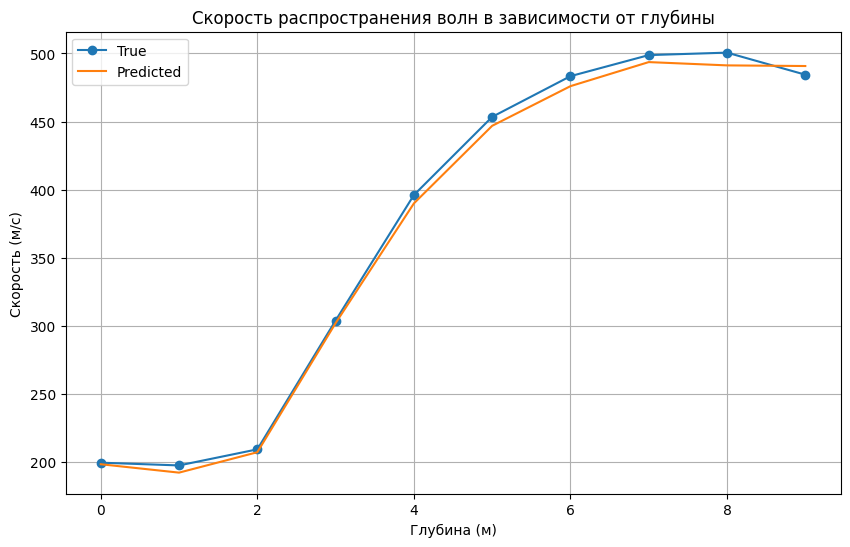

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[0], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

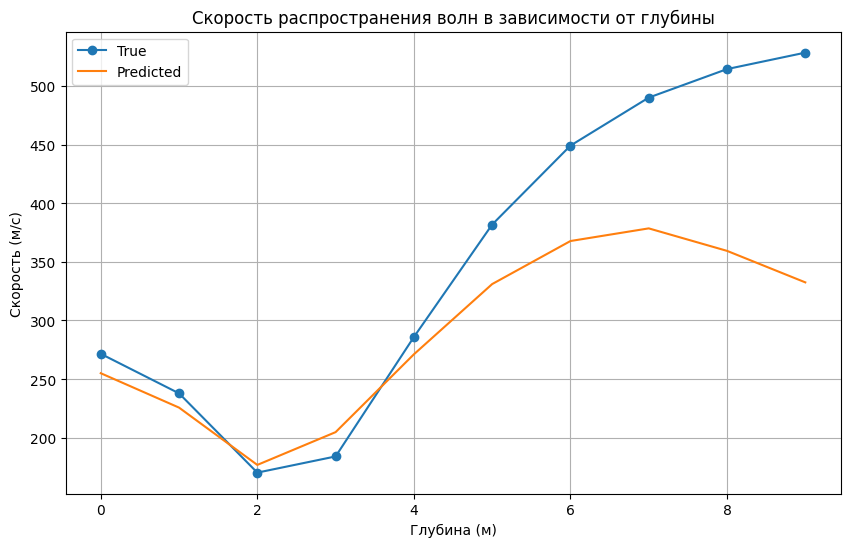

In [33]:
a = model(torch.tensor(X_val[1].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[1], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

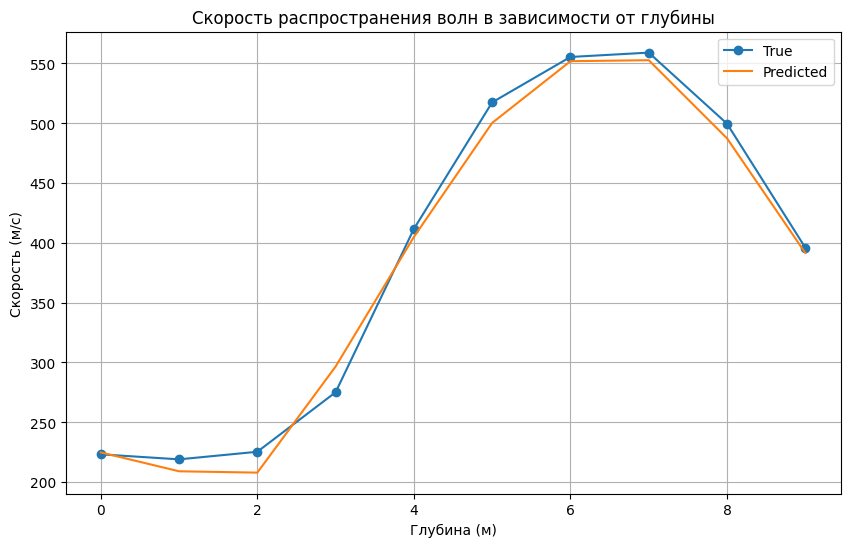

In [34]:
a = model(torch.tensor(X_val[2].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[2], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

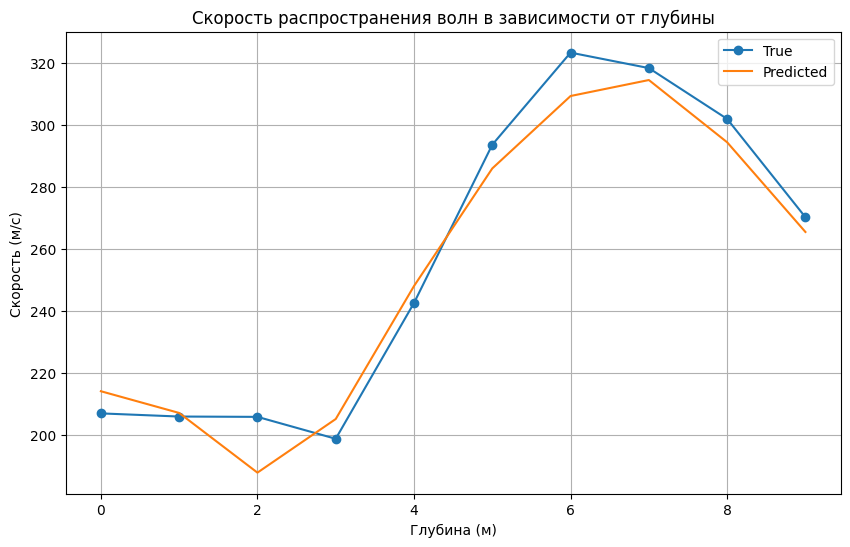

In [35]:
a = model(torch.tensor(X_val[3].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[3], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

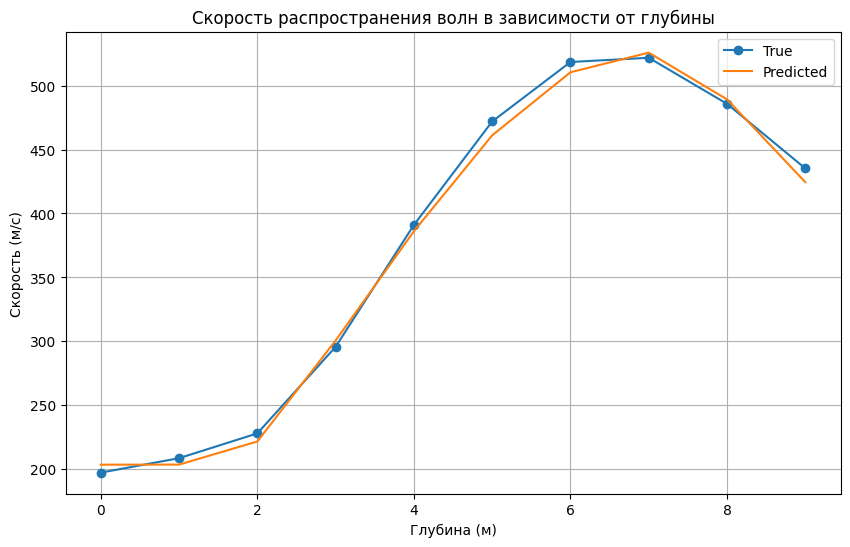

In [36]:
a = model(torch.tensor(X_val[4].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[4], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

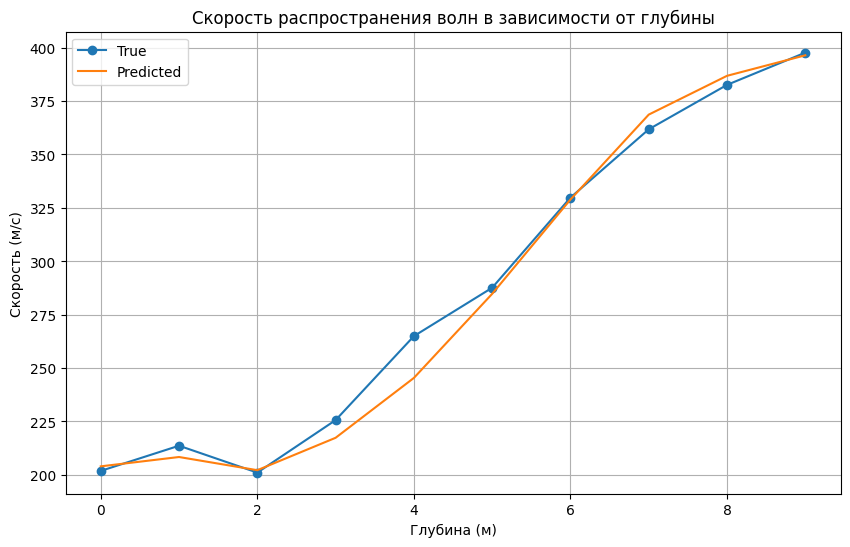

In [37]:
a = model(torch.tensor(X_val[5].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[5], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()

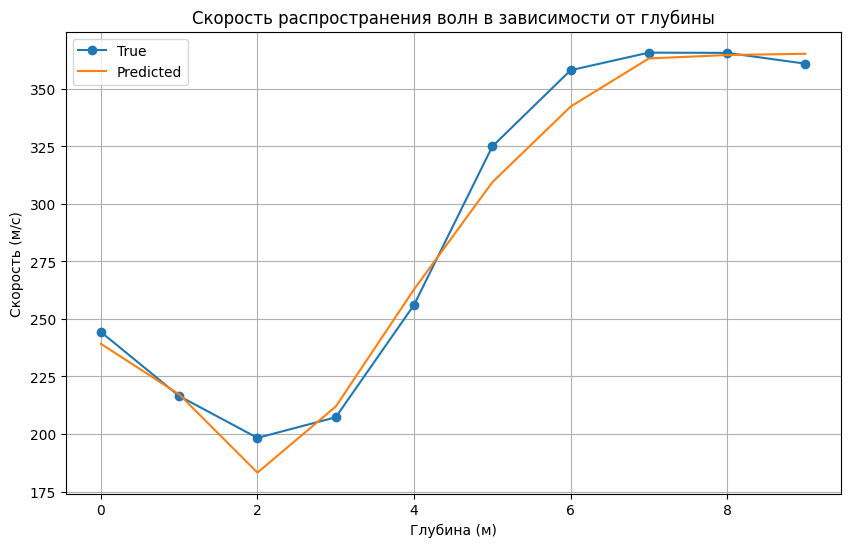

In [38]:
a = model(torch.tensor(X_val[8].reshape((1,10))).to(device)).cpu().detach().numpy()
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10), y_val.iloc[8], marker='o', label='True')
plt.plot(np.arange(10), a, label='Predicted')
plt.xlabel('Глубина (м)')
plt.ylabel('Скорость (м/с)')
plt.title('Скорость распространения волн в зависимости от глубины')
plt.grid(True)
plt.legend()
plt.show()